In [11]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import random
from random import shuffle

Populating the interactive namespace from numpy and matplotlib


(33, 33)


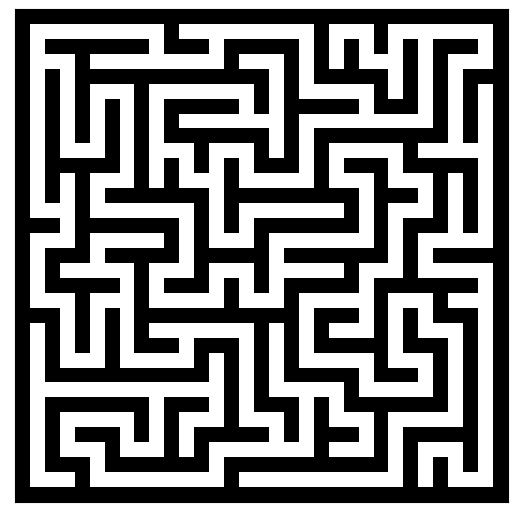

In [12]:
height = 16 # Vertical Height
width = 16  # Horizontal Width

# Generic Method for creating the Maze.
#
# Takes in the following:
#   | paramName  | DataType         | Default |
#   |-----------------------------------------|
#   | width      | int              | 16      |
#   | height     | int              | 16      |
#   |-----------------------------------------|
def make_maze(width: int = 16, height: int = 16):
    # Creates a 2D array of binary integers (0,1) of X-width and Y-height, used to keep track of visited positions as part of the traversal algorithm.
    visited = [[0] * width + [1] for _ in range(height)] + [[1] * (width + 1)]
    # Create a 2D array to represent the vertical columns in the 'Graph'
    vertical = [["10"] * width + ['1'] for _ in range(height)] + [[]]
    # Create a 2D array to represent the horizontal rows in the 'Graph'
    horizontal = [["11"] * width + ['1'] for _ in range(height + 1)]

    # Internal Method for actually generating the maze.
    # Uses 'step_x' and 'step_y' to represent the current x and y coordinates of the path.
    # The list is then shuffled to randomize the path.
    # The method then iterates over the list of coordinates and checks if the coordinate has been visited before.
    # If it has, it is skipped. If it hasn't, the vertical and horizontal arrays are updated to create the walls that are being traversed through.
    # Finally, the method is called recursively with the new coordinates and the process repeats until all the possible paths have been explored.
    #
    # Takes in the following:
    #   | paramName   | DataType         | Default |
    #   |------------------------------------------|
    #   | step_x      | int              | -       |
    #   | step_y      | int              | -       |
    #   |------------------------------------------|
    def walk(step_x: int, step_y: int):
        visited[step_y][step_x] = 1                                 # Marks the starting position as visited
        offsets = [(step_x - 1, step_y),                            # Position to the (W)
                    (step_x, step_y + 1),                           # Position to the (N)
                    (step_x + 1, step_y),                           # Position to the (E)
                    (step_x, step_y - 1)]                           # Position to the (S)
        shuffle(offsets)                                            # Shuffle the list
        for (x, y) in offsets:                                      # Loop over each position in the offset array
            if visited[y][x]: continue                              # If it's already visited then skip
            if x == step_x: horizontal[max(step_y, y)][x] = "10"    # If x is the original x-coord, then set the horizontal rows position value to '10'
            if y == step_y: vertical[y][max(step_x, x)] = "00"      # If y is the original y-coord, then set the vertical column position value to '10'
            walk(x, y)                                              # Recursively call itself

    walk(np.random.randint(width), np.random.randint(height))       # Call 'walk' from a random x and y within 16 and near-infinity

    s = "" # Maze String
    # For Loop that iterates over all columns and rows and merges them into one.
    for (a, b) in zip(horizontal, vertical):
        s += ''.join(a + ['\n'] + b + ['\n']) # Joins the horizontal and vertical arrays into a singular "maze" string

    maze = [] # Maze Structure
    for line in s.split("\n"):              # Loops over
        if line != "":                      # If the line is not empty
            row = []                        # Creates a row array structure
            for instance in line:           # For each 'instance' of a character in the line
                row.append(int(instance))   # Append the integer-converted character to the row array
            maze.append(row)                # Append the row to the maze array

    return maze # Returns the generated maze

# Specify the size of the figure as 640x640px
plt.figure(figsize=(6.4,6.4))
# Create a Numpy.array containing the randomly generated mazed.
maze = np.array(make_maze(height, width))
# Disables the default grid texture
plt.grid()
# Disables the X and Y ticks
plt.xticks(())
plt.yticks(())
# Shows a visual representation of the maze, based of its 0 and 1 values
plt.imshow(maze, cmap='Greys')
# Print the shape of the maze
print(maze.shape)

In [21]:
# Returns a Random X/Y coordinate combo
# This coordinate combo is validated to not be a wall/border (1)
def getRandomTarget():
    x = random.randint(1, width)
    y = random.randint(1, height)
    while maze[x][y] == 1:
        x = random.randint(1, width)
        y = random.randint(1, height)
    print(x, y)
    return [x,y]

# Returns a base policy which is based off the heuristic value of the start position and the target position:
# Values in the array are in order: N, S, W, E
def get_base_policy(start: [int,int] = [1,1], target: [int,int] = [height*2-1, width*2-1]):
    x1, y1 = start
    x2, y2 = target
    if x2 - x1 >= 0 and y2 - y1 >= 0:
        return np.array([0.22, 0.28, 0.22, 0.28])
    elif x2 - x1 >= 0 and y2 - y1 <= 0:
        return np.array([0.28, 0.22, 0.22, 0.28])
    elif x2 - x1 <= 0 and y2 - y1 >= 0:
        return np.array([0.22, 0.28, 0.28, 0.22])
    elif x2 - x1 <= 0 and y2 - y1 <= 0:
        return np.array([0.28, 0.22, 0.28, 0.22])
    else:
        return np.array([0.25, 0.25, 0.25, 0.25])

def create_base_policy_array(start: [int,int] = [1,1], target: [int,int] = [height*2-1, width*2-1]):
    w = width * 2
    h = height * 2
    base_policy_array = np.zeros((w,h,4))
    for x in range(w):
        for y in range(h):
            base_policy_array[x, y] = get_base_policy(start=[x,y], target=target)
    return base_policy_array

def train_policy(maze, policy, start: [int, int] = [1, 1], target: [int, int] = [width * 2 - 1, height * 2 - 1], iter_lengths: [] = [], learning_rate: float = 0.01, iterations: int = 256):
    allVisited = []
    for i in range(iterations):
        visited=np.zeros((width * 2 + 1, height * 2 + 1))
        x1, y1 = start
        x2, y2 = target
        curr_x = x1
        curr_y = y1
        x_offset = [0, 1, 0, -1]
        y_offset = [1, 0, -1, 0]
        trackX = [curr_x]
        trackY = [curr_y]
        actions = []
        visited[curr_x][curr_y] = 1
        while curr_x != x2 or curr_y != y2:
            action = np.random.choice([0,1,2,3],p=policy[curr_x][curr_y])
            temp_x = curr_x + x_offset[action]
            temp_y = curr_y + y_offset[action]
            if maze[temp_x][temp_y] == 0:
                curr_x = temp_x
                curr_y = temp_y
                visited[curr_x][curr_y] = 1
                trackX.append(curr_x)
                trackY.append(curr_y)
                actions.append(action)

        for j in range(len(actions)):
            policy[trackX[j]][trackY[j]][actions[j]] += learning_rate

        for j in range(width * 2):
            for k in range(height * 2):
                policy[j][k] /= policy[j][k].sum()

        iter_lengths.append(len(actions))
        allVisited.append(visited)

    print(f"Final Policy: {str(policy)}")
    return iter_lengths, allVisited[0], allVisited[len(allVisited)-1]

def display(maze, policy, iteration_counts: [int], worst_visited: [int], best_visited: [int]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19.2, 12.8))

    ax1.set_title('Full Maze')
    ax1.grid()
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.imshow(maze, cmap='Reds')

    ax2.set_title('Policy Maze Map')
    ax2.grid()
    ax2.set_xlim(-0.5, 32.5)
    ax2.set_ylim(32.5, -0.5)
    ax2.set_xticks(())
    ax2.set_yticks(())
    ax2.imshow(maze, cmap='Reds')
    ax2.imshow(policy)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19.2, 12.8))
    ax1.set_title('Visisted positions for first run of RL Algorithm')
    ax1.imshow(maze, cmap='Reds')
    ax1.imshow(worst_visited, cmap='Greys')
    ax2.set_title('Visisted positions for final run of RL Algorithm')
    ax2.imshow(maze, cmap='Reds')
    ax2.imshow(best_visited, cmap='Greys')

    fig, ax = plt.subplots(figsize=(19.2, 12.8))
    ax.set_title('Iteration-Cycle Sizes')
    ax.plot(iteration_counts)

Final Policy: [[[2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  ...
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]]

 [[2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [5.27355528e-01 4.72644472e-01 6.42103318e-13 8.17222405e-13]
  [5.65430291e-01 2.54377956e-12 4.34569709e-01 2.54377956e-12]
  ...
  [6.82828713e-01 3.08918291e-08 3.17171226e-01 3.08918291e-08]
  [6.82840080e-01 1.64179475e-09 3.17159917e-01 1.64179475e-09]
  [2.61130491e-11 6.12861340e-01 3.87138660e-01 3.32347897e-11]]

 [[2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [3.13016577e-11 4.42144770e-01 3.13016577e-11 5.57855230e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  ...
  [2

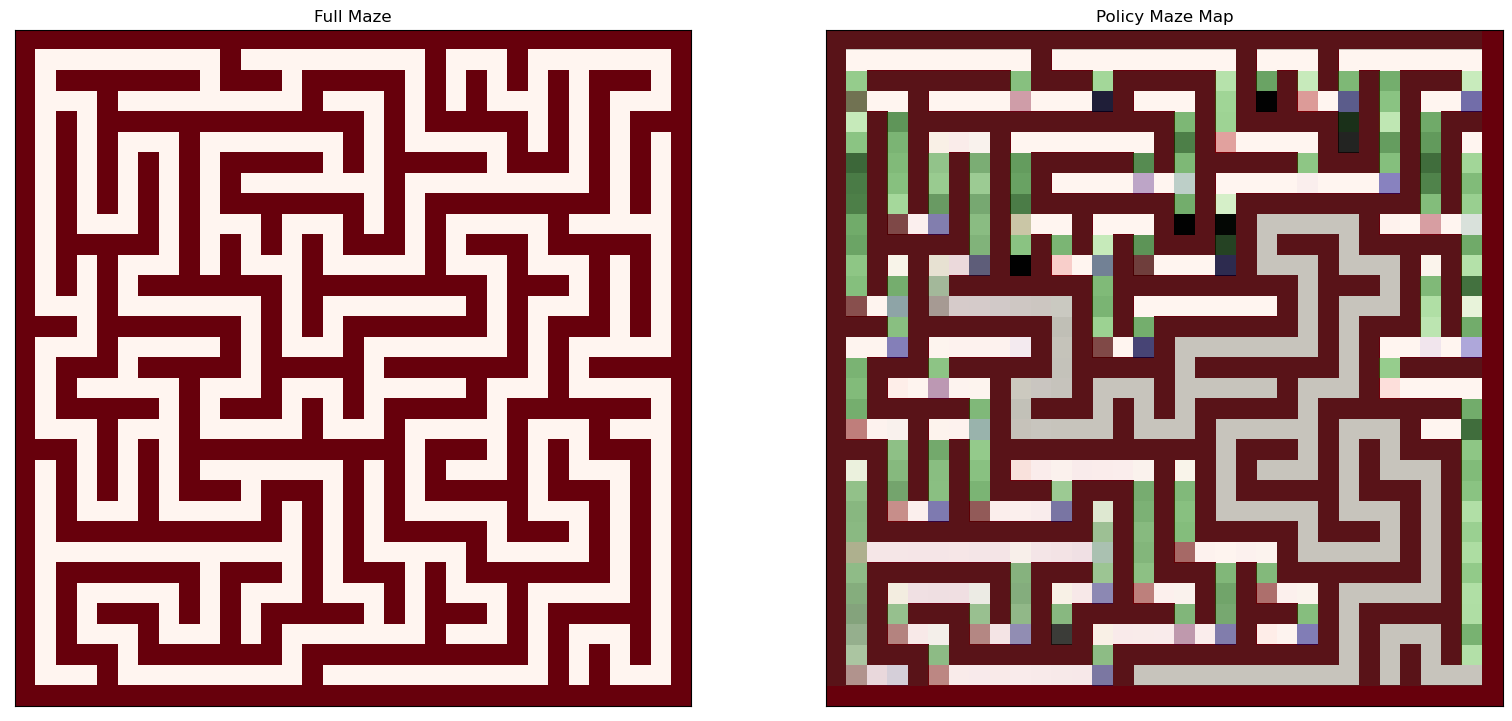

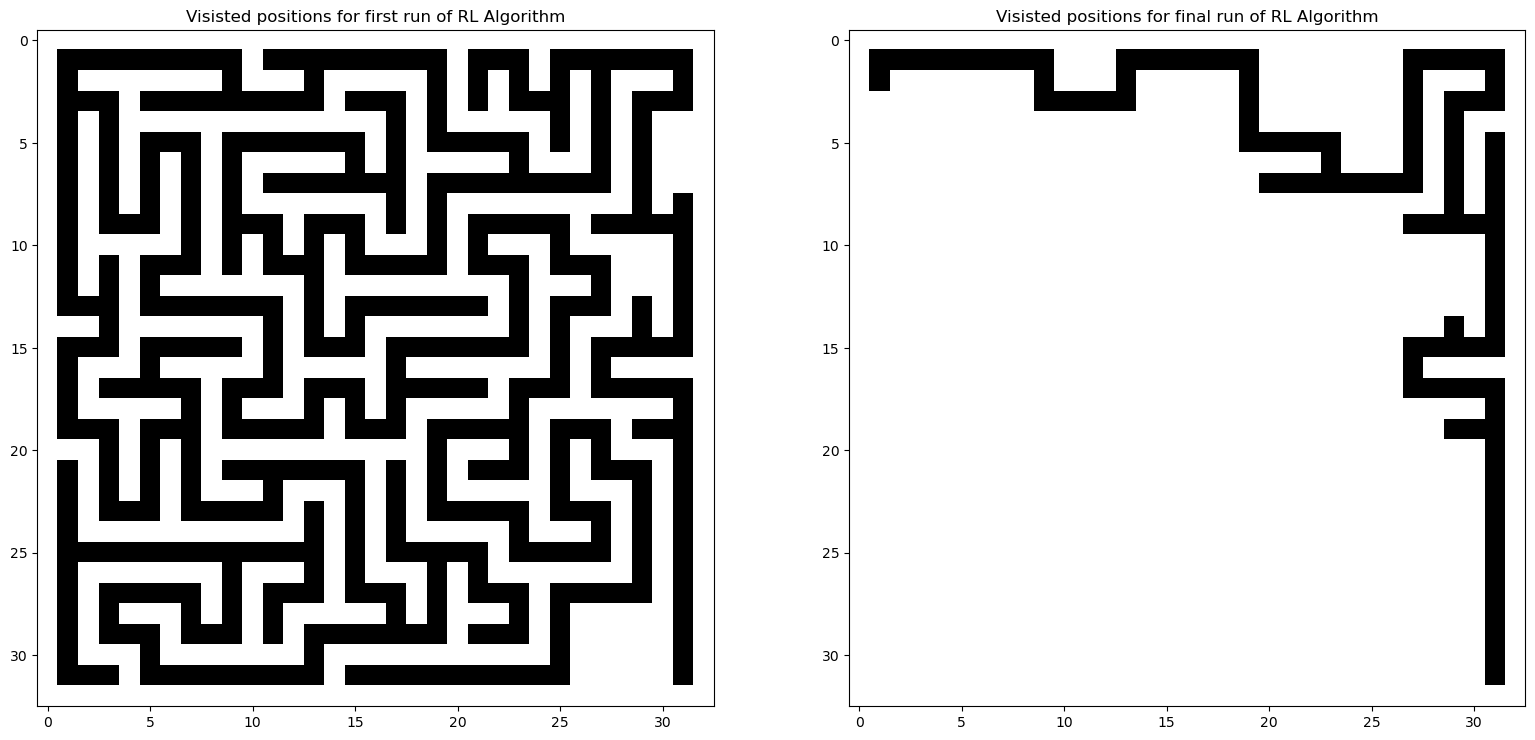

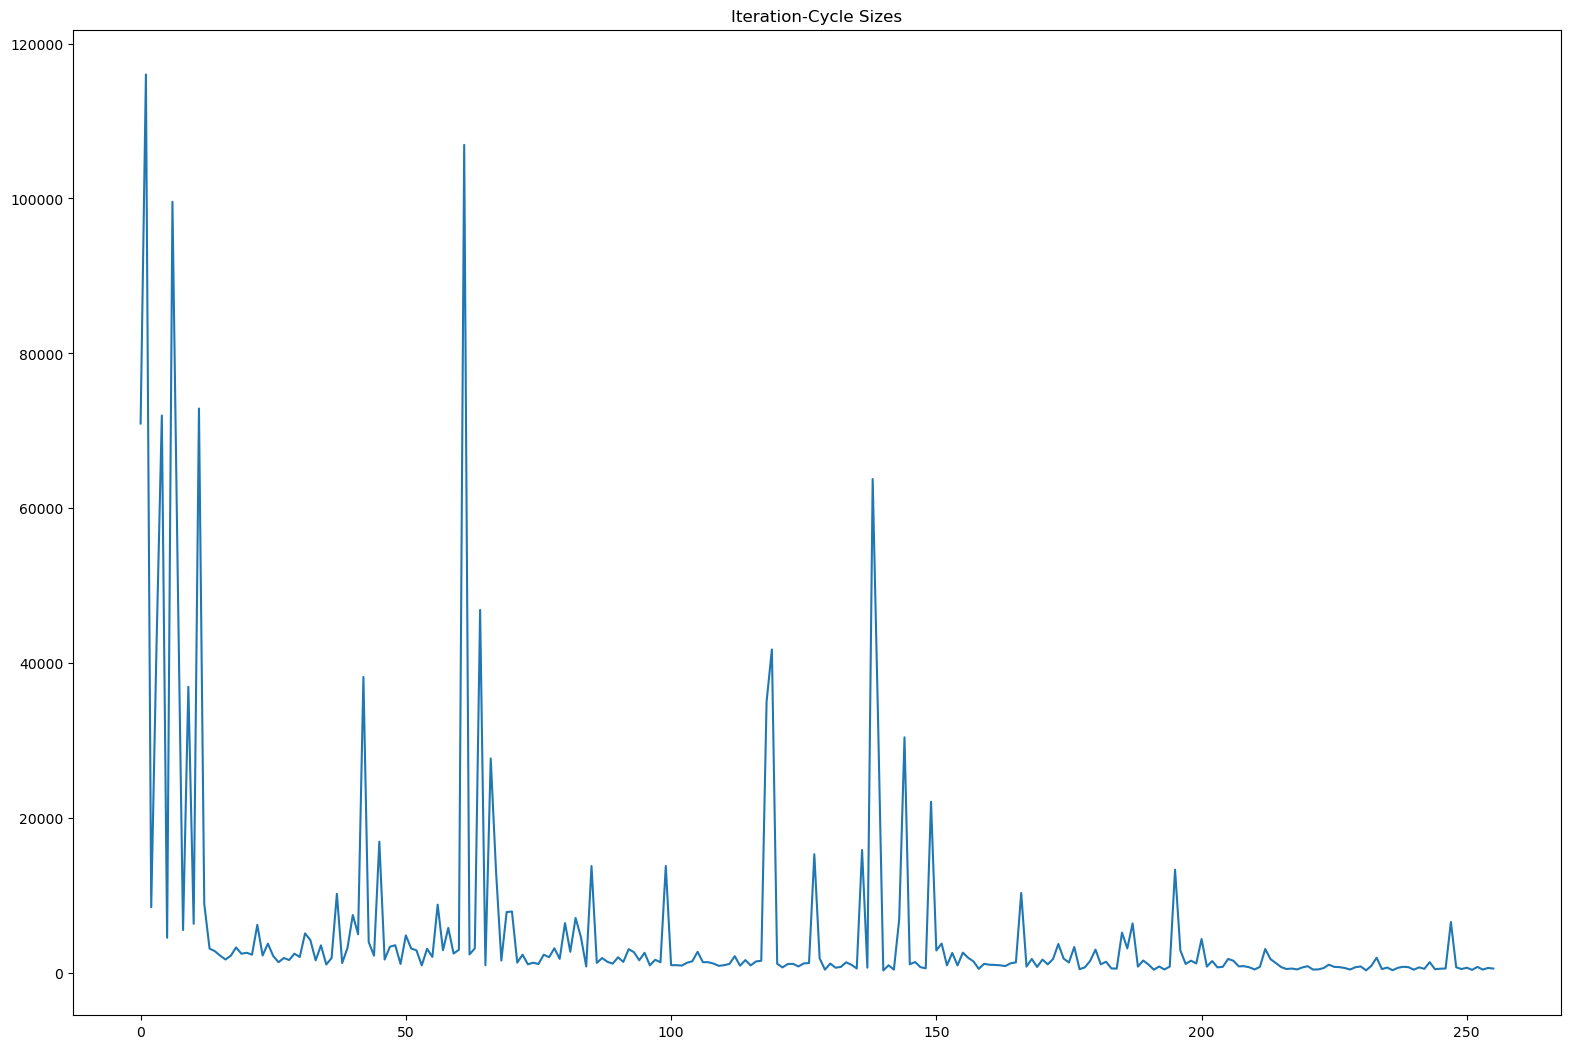

In [22]:
# Starting Position
start = [1,1]
# Target Position
target = [width * 2 - 1, height * 2 - 1]
# Learning Rate
learningRate = 0.01
# Learning Iterations
iterations = 256

L, WV, BV = train_policy(maze, create_base_policy_array(start, target), start=start, target=target, learning_rate=learningRate, iterations=iterations)
display(maze, policy, L, WV, BV)

In [15]:
#L, WV, BV = train_policy(maze, create_base_policy_array(start, target), start=start, target=target, learning_rate=0.025, iterations=512)
#display(maze, policy, L, WV, BV)

In [16]:
#L, WV, BV = train_policy(maze, create_base_policy_array(start, target), start=start, target=target, learning_rate=0.05, iterations=1024)
#display(maze, policy, L, WV, BV)

In [17]:
# Starting Position
#start = getRandomTarget()

#L, WV, BV = train_policy(maze, create_base_policy_array(start, target), start=start, target=target, learning_rate=0.1, iterations=2048)
#display(maze, policy, L, WV, BV)